In [ ]:
"""

Date : August 1, 2019

Author : Heather Landry Drexler

This script will develop plots for Figure 3 of the nanoCOP manuscript.

This script requires the files produced by the script nanoCOP_splice_df_datasets.ipynb
                                            

"""


In [18]:
import numpy as np
import pandas as pd
import pysam
from collections import Counter

import math

import scipy
from scipy import stats
from scipy.stats import ttest_ind, ttest_ind_from_stats, chi2_contingency
from scipy.special import stdtr

import pybedtools
from pybedtools import BedTool

import matplotlib.pyplot as plt
import re
% matplotlib inline
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)

import seaborn as sns
sns.set_style("white")

In [3]:
# FIGURE 3B - HeLa NP-seq PlaB vs. DMSO percent spliced plot

libraries=['DMSO','PlaB']
splicing_index_matrix=[]

for i in libraries: 
    splicing_index_df = pd.read_table("/path/to/HeLa_NPseq_%s_noAlt_splicing_index.txt" %i, \
                          dtype={"gene": str, "intron": int, "chr":str, "start": int, "end": int, \
                                 "strand": str, "5SS_count": float, "3SS_count": float, "splice_count": float})
    
    sample = i.split("_")[0]
    
    global_3SS_count = sum(splicing_index_df['3SS_count'])
    global_spliced_count = sum(splicing_index_df['splice_count'])
    global_percentSpliced = sum(splicing_index_df['splice_count']) / (sum(splicing_index_df['splice_count'])+sum(splicing_index_df['3SS_count']))
                            
    splicing_index_matrix.append([sample,global_3SS_count,global_spliced_count,global_percentSpliced])

splicing_index_matrix_df = pd.DataFrame(splicing_index_matrix)    
splicing_index_matrix_df.columns = ['sample','unspliced_count','spliced_count','percent_spliced']


In [4]:
splicing_index_matrix_df

,sample,unspliced_count,spliced_count,percent_spliced
0,DMSO,63348.0,4948248.0,0.987360
1,PlaB,198392.0,4859524.0,0.960776


In [5]:
# prepare dataset to plot the global percent spliced values between samples
samples=['DMSO','PlaB']
plot_percentSpliced_matrix=[]
for i in samples:
    mean = np.average(splicing_index_matrix_df[splicing_index_matrix_df['sample']==i]['percent_spliced'])*100
    high = np.max(splicing_index_matrix_df[splicing_index_matrix_df['sample']==i]['percent_spliced'])*100
    low = np.min(splicing_index_matrix_df[splicing_index_matrix_df['sample']==i]['percent_spliced'])*100
    plot_percentSpliced_matrix.append([i,mean,high,low])
    
plot_percentSpliced_matrix_df = pd.DataFrame(plot_percentSpliced_matrix)    
plot_percentSpliced_matrix_df.columns = ['sample','average','max','min']

In [6]:
plot_percentSpliced_matrix_df

,sample,average,max,min
0,DMSO,98.735972,98.735972,98.735972
1,PlaB,96.077594,96.077594,96.077594


In [7]:
plot_percentSpliced_matrix_df['average'][0]-plot_percentSpliced_matrix_df['average'][1]

2.658377521788168

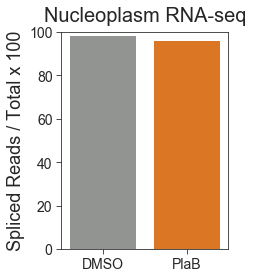

In [8]:
# plot the global percent spliced of samples in read
# box plots show the means and bars are ranges between the two samples

N = len(plot_percentSpliced_matrix_df)
ind = np.arange(N)  # the x locations for the groups

labels = plot_percentSpliced_matrix_df['sample'].values
mean = plot_percentSpliced_matrix_df['average'].values
err = plot_percentSpliced_matrix_df['max']-mean

fig, ax = plt.subplots(figsize=(3,4))
fill_color=['grey','orange']

g = sns.barplot(labels,mean,palette=sns.xkcd_palette(fill_color))
#g.errorbar(ind, mean, yerr=err, fmt="none", ecolor="black", elinewidth=1, capsize=2)

# add some text for labels, title and axes ticks
g.set_title('Nucleoplasm RNA-seq', fontsize=20, y=1.02)

# label x-axis
g.set_xticks(ind)
x_labels=['DMSO','PlaB']
g.set_xticklabels(x_labels, fontsize=16)

# add ticks to axes
ax.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)

# label y-axis
plt.rc('ytick', labelsize=16)
g.set_ylabel('Spliced Reads / Total x 100', fontsize=18)
g.set_ylim(0,100)

plt.savefig('/path/to/Figure_3B_Proudfoot_HeLa_NPseq_DMSO_vs_PlaB_percent_spliced_plot.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()

In [9]:
# get values for Fisher exact test and Chi squared test
DMSO_spliced = int(splicing_index_matrix_df[splicing_index_matrix_df['sample']=="DMSO"]['spliced_count'])
DMSO_unspliced = int(splicing_index_matrix_df[splicing_index_matrix_df['sample']=="DMSO"]['unspliced_count'])
PlaB_spliced = int(splicing_index_matrix_df[splicing_index_matrix_df['sample']=="PlaB"]['spliced_count'])
PlaB_unspliced = int(splicing_index_matrix_df[splicing_index_matrix_df['sample']=="PlaB"]['unspliced_count'])

np.array([[DMSO_spliced, DMSO_unspliced], [PlaB_spliced, PlaB_unspliced]])

array([[4948248,   63348],
       [4859524,  198392]])

In [10]:
oddsratio, pvalue = stats.fisher_exact([[DMSO_spliced, DMSO_unspliced], [PlaB_spliced, PlaB_unspliced]])
print("odds ratio: "+str(oddsratio)) # the same equation in R shows that this is <2.2e-16
print("p-value: "+str(pvalue)) # the same equation in R shows that this is <2.2e-16

odds ratio: 3.18895928185205
p-value: 0.0


In [11]:
g, pvalue, dof, expctd = chi2_contingency(np.array([[DMSO_spliced, DMSO_unspliced], [PlaB_spliced, PlaB_unspliced]]))
print("p-value: "+str(pvalue))  # the same equation in R shows that this is <2.2e-16


p-value: 0.0


In [12]:
# FIGURE 3C - HeLa mNET-seq PlaB vs. DMSO percent spliced

libraries=['DMSO','PlaB']
splicing_index_matrix=[]

for i in libraries: 
    splicing_index_df = pd.read_table("/path/to/HeLa_mNETseq_%s_noAlt_splicing_index.txt" %i, \
                          dtype={"gene": str, "intron": int, "chr":str, "start": int, "end": int, \
                                 "strand": str, "5SS_count": float, "3SS_count": float, "splice_count": float})
    
    sample = i.split("_")[0]
    
    global_3SS_count = sum(splicing_index_df['3SS_count'])
    global_spliced_count = sum(splicing_index_df['splice_count'])
    global_percentSpliced = sum(splicing_index_df['splice_count']) / (sum(splicing_index_df['splice_count'])+sum(splicing_index_df['3SS_count']))
                            
    splicing_index_matrix.append([sample,global_3SS_count,global_spliced_count,global_percentSpliced])

splicing_index_matrix_df = pd.DataFrame(splicing_index_matrix)    
splicing_index_matrix_df.columns = ['sample','unspliced_count','spliced_count','percent_spliced']


In [13]:
# prpare dataset to plot the global percent spliced values between samples
samples=['DMSO','PlaB']
plot_percentSpliced_matrix=[]
for i in samples:
    mean = np.average(splicing_index_matrix_df[splicing_index_matrix_df['sample']==i]['percent_spliced'])*100
    high = np.max(splicing_index_matrix_df[splicing_index_matrix_df['sample']==i]['percent_spliced'])*100
    low = np.min(splicing_index_matrix_df[splicing_index_matrix_df['sample']==i]['percent_spliced'])*100
    plot_percentSpliced_matrix.append([i,mean,high,low])
    
plot_percentSpliced_matrix_df = pd.DataFrame(plot_percentSpliced_matrix)    
plot_percentSpliced_matrix_df.columns = ['sample','average','max','min']

In [14]:
plot_percentSpliced_matrix_df

,sample,average,max,min
0,DMSO,48.988091,48.988091,48.988091
1,PlaB,38.874372,38.874372,38.874372


In [15]:
plot_percentSpliced_matrix_df['average'][0]-plot_percentSpliced_matrix_df['average'][1]

10.113719437883866

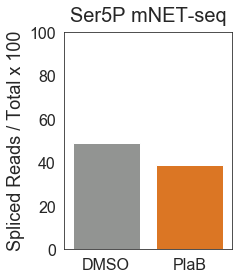

In [16]:
# plot the global percent spliced of samples in read
# box plots show the means and bars are ranges between the two samples

N = len(plot_percentSpliced_matrix_df)
ind = np.arange(N)  # the x locations for the groups

labels = plot_percentSpliced_matrix_df['sample'].values
mean = plot_percentSpliced_matrix_df['average'].values
err = plot_percentSpliced_matrix_df['max']-mean

fig, ax = plt.subplots(figsize=(3,4))
fill_color=['grey','orange']

g = sns.barplot(labels,mean,palette=sns.xkcd_palette(fill_color))
#g.errorbar(ind, mean, yerr=err, fmt="none", ecolor="black", elinewidth=1, capsize=2)

# add some text for labels, title and axes ticks
g.set_title('Ser5P mNET-seq', fontsize=20, y=1.02)

# label x-axis
g.set_xticks(ind)
x_labels=['DMSO','PlaB']
g.set_xticklabels(x_labels, fontsize=16)

# add ticks to axes
ax.tick_params(direction='out', length=5, width=1)

# label y-axis
g.set_ylim(0,100)
plt.rc('ytick', labelsize=16)
g.set_ylabel('Spliced Reads / Total x 100', fontsize=18)

plt.savefig('/path/to/Figure_3C_Proudfoot_HeLa_mNETseq_DMSO_vs_PlaB_percent_spliced_plot.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()

In [17]:
# get values for Fisher exact test and Chi squared test
DMSO_spliced = int(splicing_index_matrix_df[splicing_index_matrix_df['sample']=="DMSO"]['spliced_count'])
DMSO_unspliced = int(splicing_index_matrix_df[splicing_index_matrix_df['sample']=="DMSO"]['unspliced_count'])
PlaB_spliced = int(splicing_index_matrix_df[splicing_index_matrix_df['sample']=="PlaB"]['spliced_count'])
PlaB_unspliced = int(splicing_index_matrix_df[splicing_index_matrix_df['sample']=="PlaB"]['unspliced_count'])

np.array([[DMSO_spliced, DMSO_unspliced], [PlaB_spliced, PlaB_unspliced]])

array([[166560, 173441],
       [ 91195, 143394]])

In [18]:
oddsratio, pvalue = stats.fisher_exact([[DMSO_spliced, DMSO_unspliced], [PlaB_spliced, PlaB_unspliced]])
print("odds ratio: "+str(oddsratio)) # the same equation in R shows that this is <2.2e-16
print("p-value: "+str(pvalue)) # the same equation in R shows that this is <2.2e-16

odds ratio: 1.510006772957902
p-value: 0.0


In [19]:
g, pvalue, dof, expctd = chi2_contingency(np.array([[DMSO_spliced, DMSO_unspliced], [PlaB_spliced, PlaB_unspliced]]))
print("p-value: "+str(pvalue))  # the same equation in R shows that this is <2.2e-16


p-value: 0.0


In [20]:
# FIGURE 3D - nanoCOP PlaB vs. DMSO percent spliced

# function for merging dictionaries
# from: https://stackoverflow.com/questions/38987/how-to-merge-two-dictionaries-in-a-single-expression
def merge_dicts(*dict_args):
    """
    Given any number of dicts, shallow copy and merge into a new dict,
    precedence goes to key value pairs in latter dicts.
    """
    result = {}
    for dictionary in dict_args:
        result.update(dictionary)
    return result


def get_read_splicing_counts(name, read_junctions):
    
    read_property = []

    # loop through all reads in the dictionary
    for read in read_junctions.keys():

        # make a set for all intron pairs within a read
        # this will avoid duplicate pairs being called due to alternative splicing
        uniq_splice_pattern = set()

        # loop through all genes that has introns that a read maps to
        for gene in read_junctions[read].keys():

            # only go through genes that have 2 or more introns
            if (len(read_junctions[read][gene]) > 1 ):

                # characterize the number of spliced and unspliced introns in the read
                splice_status = [row[6] for row in read_junctions[read][gene]]
                splice_status_join = '_'.join(splice_status)
                status_count = Counter(splice_status)

                # only process the file if intron pattern hasn't been seen previously
                # for a gene that this read aligns to
                if (splice_status_join not in uniq_splice_pattern):
                    uniq_splice_pattern.add(splice_status_join)

                    spliced_count = status_count['YES']
                    unspliced_count = status_count['NO']

                    if (unspliced_count>1) and (spliced_count==0):
                        read_property.append([read, gene, 'all_unspliced'])

                    if (unspliced_count==0) and (spliced_count>1):
                        read_property.append([read, gene, 'all_spliced'])

                    if (unspliced_count>=1) and (spliced_count>=1):
                        read_property.append([read, gene, 'intermediate'])

    read_splicing_df = pd.DataFrame(read_property)
    read_splicing_df.columns = ['read','gene','splicing_status']        

    count = []
    spliced_count = len(read_splicing_df[read_splicing_df['splicing_status']=='all_spliced'])
    unspliced_count = len(read_splicing_df[read_splicing_df['splicing_status']=='all_unspliced'])
    intermediate_count = len(read_splicing_df[read_splicing_df['splicing_status']=='intermediate'])
    count.append([name, spliced_count, unspliced_count, intermediate_count])

    count_df = pd.DataFrame(count)
    count_df.columns = ['sample','all_spliced','all_unspliced','intermediate']

    return read_splicing_df, count_df


def get_total_splice(name, read_junctions):
    
    read_property = []

    # loop through all reads in the dictionary
    for read in read_junctions.keys():

        # make a set for all intron pairs within a read
        # this will avoid duplicate pairs being called due to alternative splicing
        uniq_splice_pattern = set()

        # loop through all genes that has introns that a read maps to
        for gene in read_junctions[read].keys():

            # characterize the number of spliced and unspliced introns in the read
            splice_status = [row[6] for row in read_junctions[read][gene]]
            splice_status_join = '_'.join(splice_status)
            status_count = Counter(splice_status)

            # only process the file if intron pattern hasn't been seen previously
            # for a gene that this read aligns to
            if (splice_status_join not in uniq_splice_pattern):
                uniq_splice_pattern.add(splice_status_join)

                spliced_count = status_count['YES']
                unspliced_count = status_count['NO']

                if (spliced_count>=1):
                    read_property.append([read, gene, 'spliced'])

                if (spliced_count==0):
                    read_property.append([read, gene, 'not_spliced'])


    read_splicing_df = pd.DataFrame(read_property)
    read_splicing_df.columns = ['read','gene','splicing_status']        

    count = []
    spliced_count = len(read_splicing_df[read_splicing_df['splicing_status']=='spliced'])
    unspliced_count = len(read_splicing_df[read_splicing_df['splicing_status']=='not_spliced'])
    count.append([name, spliced_count, unspliced_count])

    count_df = pd.DataFrame(count)
    count_df.columns = ['sample','spliced','not_spliced']

    return count_df




In [26]:
# load dictionaries with all intron junctions that a read spans

# K562
K562_DMSO_1_splice_dictionary = np.load('/path/to/K562_DMSO_1_splicing_dictionary.npy', encoding = 'latin1').item() 
K562_DMSO_2_splice_dictionary = np.load('/path/to/K562_DMSO_2_splicing_dictionary.npy', encoding = 'latin1').item()
K562_PlaB_1_splice_dictionary = np.load('/path/to/K562_PlaB_1_splicing_dictionary.npy', encoding = 'latin1').item()
K562_PlaB_2_splice_dictionary = np.load('/path/to/K562_PlaB_2_splicing_dictionary.npy', encoding = 'latin1').item()

# S2
S2_DMSO_1_splice_dictionary = np.load('/path/to/S2_DMSO_1_splicing_dictionary.npy', encoding = 'latin1').item()
S2_DMSO_2_splice_dictionary = np.load('/path/to/S2_DMSO_2_splicing_dictionary.npy', encoding = 'latin1').item()
S2_PlaB_1a_splice_dictionary = np.load('/path/to/S2_PlaB_1a_splicing_dictionary.npy', encoding = 'latin1').item()
S2_PlaB_1b_splice_dictionary = np.load('/path/to/S2_PlaB_1b_splicing_dictionary.npy', encoding = 'latin1').item()
S2_PlaB_2_splice_dictionary = np.load('/path/to/S2_PlaB_2_splicing_dictionary.npy', encoding = 'latin1').item()

# merge DMSO and PlaB dictionaries
K562_DMSO_splice_dictionary = merge_dicts(K562_DMSO_1_splice_dictionary, K562_DMSO_2_splice_dictionary) 
K562_PlaB_splice_dictionary = merge_dicts(K562_PlaB_1_splice_dictionary, K562_PlaB_2_splice_dictionary) 

S2_DMSO_splice_dictionary = merge_dicts(S2_DMSO_1_splice_dictionary, S2_DMSO_2_splice_dictionary) 
S2_PlaB_splice_dictionary = merge_dicts(S2_PlaB_1a_splice_dictionary, S2_PlaB_1b_splice_dictionary, S2_PlaB_2_splice_dictionary) 


In [30]:
# collect splicing counts from K562 cells
DMSO_splicing_status, DMSO_splicing_counts = get_read_splicing_counts('K562_DMSO',K562_DMSO_splice_dictionary)
PlaB_splicing_status, PlaB_splicing_counts = get_read_splicing_counts('K562_PlaB',K562_PlaB_splice_dictionary)

# label splicing counts
DMSO_splicing_counts['sample'] = 'DMSO'
PlaB_splicing_counts['sample'] = 'PlaB'

# combine splicing counts
K562_splicing_counts = []
K562_splicing_counts.append([DMSO_splicing_counts['sample'].iloc[0],DMSO_splicing_counts['all_unspliced'].sum(),
                           DMSO_splicing_counts['intermediate'].sum(), DMSO_splicing_counts['all_spliced'].sum()])
K562_splicing_counts.append([PlaB_splicing_counts['sample'].iloc[0],PlaB_splicing_counts['all_unspliced'].sum(),
                           PlaB_splicing_counts['intermediate'].sum(), PlaB_splicing_counts['all_spliced'].sum()])

K562_splicing_counts_df = pd.DataFrame(K562_splicing_counts)
K562_splicing_counts_df.columns = ['sample','all_unspliced','intermediate','all_spliced']

# define percentiles for splicing patterns
df1 = K562_splicing_counts_df.copy()
df2 = K562_splicing_counts_df.copy()

df2['all_spliced'] = df1['all_spliced']/(df1['all_spliced']+df1['intermediate']+df1['all_unspliced'])*100
df2['intermediate'] = (df1['all_spliced']+df1['intermediate'])/(df1['all_spliced']+df1['intermediate']+df1['all_unspliced'])*100
df2['all_unspliced'] = (df1['all_spliced']+df1['intermediate']+df1['all_unspliced'])/(df1['all_spliced']+df1['intermediate']+df1['all_unspliced'])*100

K562_splicing_percent_df = df2.copy()


In [31]:
K562_splicing_counts_df

,sample,all_unspliced,intermediate,all_spliced
0,DMSO,10348,4241,4297
1,PlaB,11522,585,822


In [32]:
K562_splicing_percent_df

,sample,all_unspliced,intermediate,all_spliced
0,DMSO,100.0,45.208091,22.752303
1,PlaB,100.0,10.882512,6.357800


In [33]:
# collect splicing counts from K562 cells
DMSO_splicing_status, DMSO_splicing_counts = get_read_splicing_counts('S2_DMSO',S2_DMSO_splice_dictionary)
PlaB_splicing_status, PlaB_splicing_counts = get_read_splicing_counts('S2_PlaB',S2_PlaB_splice_dictionary)

# label splicing counts
DMSO_splicing_counts['sample'] = 'DMSO'
PlaB_splicing_counts['sample'] = 'PlaB'

# combine splicing counts
S2_splicing_counts = []
S2_splicing_counts.append([DMSO_splicing_counts['sample'].iloc[0],DMSO_splicing_counts['all_unspliced'].sum(),
                           DMSO_splicing_counts['intermediate'].sum(), DMSO_splicing_counts['all_spliced'].sum()])
S2_splicing_counts.append([PlaB_splicing_counts['sample'].iloc[0],PlaB_splicing_counts['all_unspliced'].sum(),
                           PlaB_splicing_counts['intermediate'].sum(), PlaB_splicing_counts['all_spliced'].sum()])

S2_splicing_counts_df = pd.DataFrame(S2_splicing_counts)
S2_splicing_counts_df.columns = ['sample','all_unspliced','intermediate','all_spliced']

# define percentiles for splicing patterns
df1 = S2_splicing_counts_df.copy()
df2 = S2_splicing_counts_df.copy()

df2['all_spliced'] = df1['all_spliced']/(df1['all_spliced']+df1['intermediate']+df1['all_unspliced'])*100
df2['intermediate'] = (df1['all_spliced']+df1['intermediate'])/(df1['all_spliced']+df1['intermediate']+df1['all_unspliced'])*100
df2['all_unspliced'] = (df1['all_spliced']+df1['intermediate']+df1['all_unspliced'])/(df1['all_spliced']+df1['intermediate']+df1['all_unspliced'])*100

S2_splicing_percent_df = df2.copy()


In [34]:
S2_splicing_percent_df

,sample,all_unspliced,intermediate,all_spliced
0,DMSO,100.0,52.559499,33.745303
1,PlaB,100.0,9.903319,7.159655


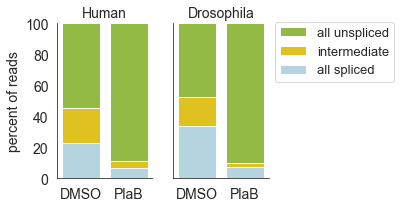

In [35]:
fig, ((ax1, ax2)) = plt.subplots(ncols=2, nrows=1, sharex=True, sharey=True, figsize=(4,3))

# Plot the total reads
sns.barplot(x="sample", y="all_unspliced", data=K562_splicing_percent_df,
            label="all unspliced", color="yellowgreen", ax=ax1)

# Plot the level of intermediate + unspliced reads
sns.barplot(x="sample", y="intermediate", data=K562_splicing_percent_df,
            label="intermediate", color="gold", ax=ax1)

# Plot the level of spliced reads
sns.barplot(x="sample", y="all_spliced", data=K562_splicing_percent_df,
            label="all spliced", color="lightblue", ax=ax1)


# Plot the total reads
sns.barplot(x="sample", y="all_unspliced", data=S2_splicing_percent_df,
            label="all unspliced", color="yellowgreen", ax=ax2)

# Plot the level of intermediate + unspliced reads
sns.barplot(x="sample", y="intermediate", data=S2_splicing_percent_df,
            label="intermediate", color="gold", ax=ax2)

# Plot the level of spliced reads
sns.barplot(x="sample", y="all_spliced", data=S2_splicing_percent_df,
            label="all spliced", color="lightblue", ax=ax2)


ax1.set_xlabel("")
ax1.set_ylabel('percent of reads',fontsize=14)

ax2.set_xlabel("")
ax2.set_ylabel("")

plt.ylim(0,100)

ax1.tick_params(direction='out', length=5, width=1)
ax2.tick_params(direction='out', length=5, width=1)

sns.despine(top=True, right=True)

plt.legend(bbox_to_anchor=(1.00, 1.05), fontsize=13)
ax1.set_title("Human", fontsize=14)
ax2.set_title("Drosophila", fontsize=14)

plt.tight_layout()

plt.savefig('/path/to/Figure_3D_Human_Drosophila_DMSO_PlaB_splicing_percent_plot.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()


In [6]:
# FIGURE 3E - nano-COP PlaB vs. DMSO distance transcribed before splicing plots

# upload files from directory
K562_DMSO_1_splice_df = pd.read_table("/path/to/K562_DMSO_1_hg38_medIntrons_discarded_splice_df.txt",header=0)
K562_DMSO_2_splice_df = pd.read_table("/path/to/K562_DMSO_2_hg38_medIntrons_discarded_splice_df.txt",header=0)
K562_PlaB_1_splice_df = pd.read_table("/path/to/K562_PlaB_1_hg38_medIntrons_discarded_splice_df.txt",header=0)
K562_PlaB_2_splice_df = pd.read_table("/path/to/K562_PlaB_2_hg38_medIntrons_discarded_splice_df.txt",header=0)

/Users/karinechoquet/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/karinechoquet/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


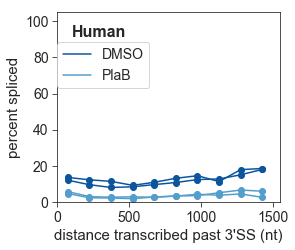

In [7]:
fig, ax = plt.subplots(figsize=(4,3.5))

######### set variables for plot #########
window = 150
plot_min = 0
plot_max = 1500      


######### get info for each sample - DMSO #########
samples=['K562_DMSO_1']

plot_list = [] 
for k in samples:
    name = '%s' % k # get name of sample
    splice_df = eval('%s_splice_df' % k) # get splicing file for this sample
    
    for i in range(int(plot_min/window-1),int(plot_max/window)):
        plot_range_low = i*window
        plot_range_high = (i+1)*window
        splicedf_range = splice_df[splice_df['dist_from_3SS'].astype(int).between(plot_range_low, plot_range_high, inclusive=True)] 
        splicedf_spliced = len(splicedf_range[splicedf_range['splice_status']=="YES"])
        splicedf_unspliced = len(splicedf_range[splicedf_range['splice_status']=="NO"])
        splicedf_undetermined = len(splicedf_range[splicedf_range['splice_status']=="UNDETERMINED"])
        if (splicedf_spliced + splicedf_unspliced) > 0: 
            splicedf_percentSpliced = (float(splicedf_spliced) / (float(splicedf_spliced) + float(splicedf_unspliced)))*100
        elif (splicedf_spliced + splicedf_unspliced) == 0: 
            splicedf_percentSpliced = 0.0

        splicedf_percentSpliced = float("{0:.3f}".format(splicedf_percentSpliced))
        count = splicedf_spliced + splicedf_unspliced
        plot_list.append([plot_range_high,name,count,float(splicedf_percentSpliced)])

plot_df = pd.DataFrame(plot_list)
plot_df.columns = ['range','name','count','percentSpliced']
N_WT = np.sum(plot_df['count'])

######### get statistics for Human #########
mean = []
stdev = []
for i in range(int(plot_min/window),int(plot_max/window)):
    plot_range_low = i*window
    plot_range_high = (i+1)*window
    plot_range_middle = (plot_range_low + plot_range_high) / 2
    mean.append([int(plot_range_middle), np.mean(plot_df[plot_df['range']==plot_range_high]['percentSpliced'])])
    stdev.append(np.std(plot_df[plot_df['range']==plot_range_high]['percentSpliced']))    

mean_plot_df = pd.DataFrame(mean)
mean_plot_df.columns = ['range','mean']
mean_plot_df['stdev'] = stdev

######### plot mean and standard deviation for Human #########

x = mean_plot_df['range'].values
y = mean_plot_df['mean'].values
err = mean_plot_df['stdev'].values

ax = plt.plot(x, y, color=sns.color_palette("Blues")[5])
plt.scatter(x, y, color=sns.color_palette("Blues")[5])


######### get info for each sample - DMSO #########
samples=['K562_DMSO_2']

plot_list = [] 
for k in samples:
    name = '%s' % k # get name of sample
    splice_df = eval('%s_splice_df' % k) # get splicing file for this sample
    
    for i in range(int(plot_min/window-1),int(plot_max/window)):
        plot_range_low = i*window
        plot_range_high = (i+1)*window
        splicedf_range = splice_df[splice_df['dist_from_3SS'].astype(int).between(plot_range_low, plot_range_high, inclusive=True)] 
        splicedf_spliced = len(splicedf_range[splicedf_range['splice_status']=="YES"])
        splicedf_unspliced = len(splicedf_range[splicedf_range['splice_status']=="NO"])
        splicedf_undetermined = len(splicedf_range[splicedf_range['splice_status']=="UNDETERMINED"])
        if (splicedf_spliced + splicedf_unspliced) > 0: 
            splicedf_percentSpliced = (float(splicedf_spliced) / (float(splicedf_spliced) + float(splicedf_unspliced)))*100
        elif (splicedf_spliced + splicedf_unspliced) == 0: 
            splicedf_percentSpliced = 0.0

        splicedf_percentSpliced = float("{0:.3f}".format(splicedf_percentSpliced))
        count = splicedf_spliced + splicedf_unspliced
        plot_list.append([plot_range_high,name,count,float(splicedf_percentSpliced)])

plot_df = pd.DataFrame(plot_list)
plot_df.columns = ['range','name','count','percentSpliced']
N_DMSO = np.sum(plot_df['count'])
plot_DMSO = plot_df.copy()

######### get statistics for Human #########
mean = []
stdev = []
for i in range(int(plot_min/window),int(plot_max/window)):
    plot_range_low = i*window
    plot_range_high = (i+1)*window
    plot_range_middle = (plot_range_low + plot_range_high) / 2
    mean.append([int(plot_range_middle), np.mean(plot_df[plot_df['range']==plot_range_high]['percentSpliced'])])
    stdev.append(np.std(plot_df[plot_df['range']==plot_range_high]['percentSpliced']))    

mean_plot_df = pd.DataFrame(mean)
mean_plot_df.columns = ['range','mean']
mean_plot_df['stdev'] = stdev

######### plot mean and standard deviation for Human #########

x = mean_plot_df['range'].values
y = mean_plot_df['mean'].values
err = mean_plot_df['stdev'].values

ax = plt.plot(x, y, color=sns.color_palette("Blues")[5], label="DMSO")
plt.scatter(x, y, color=sns.color_palette("Blues")[5])


######### get info for each sample - PlaB #########
samples=['K562_PlaB_1']

plot_list = [] 
for k in samples:
    name = '%s' % k # get name of sample
    splice_df = eval('%s_splice_df' % k) # get splicing file for this sample
    
    for i in range(int(plot_min/window-1),int(plot_max/window)):
        plot_range_low = i*window
        plot_range_high = (i+1)*window
        splicedf_range = splice_df[splice_df['dist_from_3SS'].astype(int).between(plot_range_low, plot_range_high, inclusive=True)] 
        splicedf_spliced = len(splicedf_range[splicedf_range['splice_status']=="YES"])
        splicedf_unspliced = len(splicedf_range[splicedf_range['splice_status']=="NO"])
        splicedf_undetermined = len(splicedf_range[splicedf_range['splice_status']=="UNDETERMINED"])
        if (splicedf_spliced + splicedf_unspliced) > 0: 
            splicedf_percentSpliced = (float(splicedf_spliced) / (float(splicedf_spliced) + float(splicedf_unspliced)))*100
        elif (splicedf_spliced + splicedf_unspliced) == 0: 
            splicedf_percentSpliced = 0.0

        splicedf_percentSpliced = float("{0:.3f}".format(splicedf_percentSpliced))
        count = splicedf_spliced + splicedf_unspliced
        plot_list.append([plot_range_high,name,count,float(splicedf_percentSpliced)])

plot_df = pd.DataFrame(plot_list)
plot_df.columns = ['range','name','count','percentSpliced']
N_PlaB = np.sum(plot_df['count'])
plot_PlaB = plot_df.copy()

######### get statistics for all samples #########
mean = []
stdev = []
for i in range(int(plot_min/window),int(plot_max/window)):
    plot_range_low = i*window
    plot_range_high = (i+1)*window
    plot_range_middle = (plot_range_low + plot_range_high) / 2
    mean.append([int(plot_range_middle), np.mean(plot_df[plot_df['range']==plot_range_high]['percentSpliced'])])
    stdev.append(np.std(plot_df[plot_df['range']==plot_range_high]['percentSpliced']))    

mean_plot_df = pd.DataFrame(mean)
mean_plot_df.columns = ['range','mean']
mean_plot_df['stdev'] = stdev

######### plot mean and standard deviation for all samples #########

x = mean_plot_df['range'].values
y = mean_plot_df['mean'].values
err = mean_plot_df['stdev'].values

ax = plt.plot(x, y, color=sns.color_palette("Blues")[3])
plt.scatter(x, y, color=sns.color_palette("Blues")[3])


######### get info for each sample - PlaB #########
samples=['K562_PlaB_2']

plot_list = [] 
for k in samples:
    name = '%s' % k # get name of sample
    splice_df = eval('%s_splice_df' % k) # get splicing file for this sample
    
    for i in range(int(plot_min/window-1),int(plot_max/window)):
        plot_range_low = i*window
        plot_range_high = (i+1)*window
        splicedf_range = splice_df[splice_df['dist_from_3SS'].astype(int).between(plot_range_low, plot_range_high, inclusive=True)] 
        splicedf_spliced = len(splicedf_range[splicedf_range['splice_status']=="YES"])
        splicedf_unspliced = len(splicedf_range[splicedf_range['splice_status']=="NO"])
        splicedf_undetermined = len(splicedf_range[splicedf_range['splice_status']=="UNDETERMINED"])
        if (splicedf_spliced + splicedf_unspliced) > 0: 
            splicedf_percentSpliced = (float(splicedf_spliced) / (float(splicedf_spliced) + float(splicedf_unspliced)))*100
        elif (splicedf_spliced + splicedf_unspliced) == 0: 
            splicedf_percentSpliced = 0.0

        splicedf_percentSpliced = float("{0:.3f}".format(splicedf_percentSpliced))
        count = splicedf_spliced + splicedf_unspliced
        plot_list.append([plot_range_high,name,count,float(splicedf_percentSpliced)])

plot_df = pd.DataFrame(plot_list)
plot_df.columns = ['range','name','count','percentSpliced']
N_PlaB = np.sum(plot_df['count'])

######### get statistics for all samples #########
mean = []
stdev = []
for i in range(int(plot_min/window),int(plot_max/window)):
    plot_range_low = i*window
    plot_range_high = (i+1)*window
    plot_range_middle = (plot_range_low + plot_range_high) / 2
    mean.append([int(plot_range_middle), np.mean(plot_df[plot_df['range']==plot_range_high]['percentSpliced'])])
    stdev.append(np.std(plot_df[plot_df['range']==plot_range_high]['percentSpliced']))    

mean_plot_df = pd.DataFrame(mean)
mean_plot_df.columns = ['range','mean']
mean_plot_df['stdev'] = stdev

######### plot mean and standard deviation for all samples #########

x = mean_plot_df['range'].values
y = mean_plot_df['mean'].values
err = mean_plot_df['stdev'].values

ax = plt.plot(x, y, color=sns.color_palette("Blues")[3], label="PlaB")
plt.scatter(x, y, color=sns.color_palette("Blues")[3])


plt.ylabel("percent spliced", fontsize=15)
plt.xlabel("distance transcribed past 3'SS (nt)", fontsize=15)
plt.text(100, 98, 'Human', horizontalalignment='left', verticalalignment='top', fontsize=16, weight='bold')

plt.xticks([0,500,1000,1500,2000], fontsize=14)
plt.yticks([0,20,40,60,80,100], fontsize=14)
plt.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)

plt.xlim(0,1550)
plt.ylim(0,105)
plt.legend(fontsize=14, loc=(0,0.60))

plt.savefig('/path/to/Figure_3E_Human_DMSO_vs_PlaB_distance_spliced_plot.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()

In [8]:
plot_PlaB.to_csv('/path/to/Human_PlaB_distance_transcribed_plot_df.txt', sep='\t', header=True, index=False)
plot_DMSO.to_csv('/path/to/Human_DMSO_distance_transcribed_plot_df.txt', sep='\t', header=True, index=False)

In [26]:
# upload files from directory
S2_DMSO_1_splice_df = pd.read_table("/path/to/S2_DMSO_1_dm6_medIntrons_discarded_splice_df.txt",header=0)
S2_DMSO_12_splice_df = pd.read_table("/path/to/S2_DMSO_2_dm6_medIntrons_discarded_splice_df.txt",header=0)
S2_PlaB_1a_splice_df = pd.read_table("/path/to/S2_PlaB_1a_dm6_medIntrons_discarded_splice_df.txt",header=0)
S2_PlaB_1b_splice_df = pd.read_table("/path/to/S2_PlaB_1b_dm6_medIntrons_discarded_splice_df.txt",header=0)
S2_PlaB_2_splice_df = pd.read_table("/path/to/S2_PlaB_2_dm6_medIntrons_discarded_splice_df.txt",header=0)

S2_PlaB_1_splice_df = pd.concat([S2_PlaB_1a_splice_df, S2_PlaB_1b_splice_df])

/Users/karinechoquet/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/karinechoquet/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


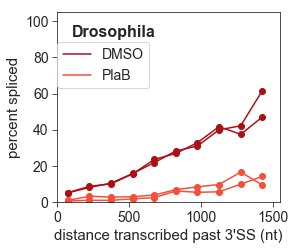

In [4]:
fig, ax = plt.subplots(figsize=(4,3.5))

######### set variables for plot #########
window = 150
plot_min = 0
plot_max = 1500      


######### get info for each sample - DMSO #########
samples=['S2_DMSO_1']

plot_list = [] 
for k in samples:
    name = '%s' % k # get name of sample
    splice_df = eval('%s_splice_df' % k) # get splicing file for this sample
    
    for i in range(int(plot_min/window-1),int(plot_max/window)):
        plot_range_low = i*window
        plot_range_high = (i+1)*window
        splicedf_range = splice_df[splice_df['dist_from_3SS'].astype(int).between(plot_range_low, plot_range_high, inclusive=True)] 
        splicedf_spliced = len(splicedf_range[splicedf_range['splice_status']=="YES"])
        splicedf_unspliced = len(splicedf_range[splicedf_range['splice_status']=="NO"])
        splicedf_undetermined = len(splicedf_range[splicedf_range['splice_status']=="UNDETERMINED"])
        if (splicedf_spliced + splicedf_unspliced) > 0: 
            splicedf_percentSpliced = (float(splicedf_spliced) / (float(splicedf_spliced) + float(splicedf_unspliced)))*100
        elif (splicedf_spliced + splicedf_unspliced) == 0: 
            splicedf_percentSpliced = 0.0

        splicedf_percentSpliced = float("{0:.3f}".format(splicedf_percentSpliced))
        count = splicedf_spliced + splicedf_unspliced
        plot_list.append([plot_range_high,name,count,float(splicedf_percentSpliced)])

plot_df = pd.DataFrame(plot_list)
plot_df.columns = ['range','name','count','percentSpliced']
N_WT = np.sum(plot_df['count'])

######### get statistics #########
mean = []
stdev = []
for i in range(int(plot_min/window),int(plot_max/window)):
    plot_range_low = i*window
    plot_range_high = (i+1)*window
    plot_range_middle = (plot_range_low + plot_range_high) / 2
    mean.append([int(plot_range_middle), np.mean(plot_df[plot_df['range']==plot_range_high]['percentSpliced'])])
    stdev.append(np.std(plot_df[plot_df['range']==plot_range_high]['percentSpliced']))    

mean_plot_df = pd.DataFrame(mean)
mean_plot_df.columns = ['range','mean']
mean_plot_df['stdev'] = stdev

######### plot mean and standard deviation#########

x = mean_plot_df['range'].values
y = mean_plot_df['mean'].values
err = mean_plot_df['stdev'].values

ax = plt.plot(x, y, color=sns.color_palette("Reds")[5])
plt.scatter(x, y, color=sns.color_palette("Reds")[5])


######### get info for each sample - DMSO #########
samples=['S2_DMSO_2']

plot_list = [] 
for k in samples:
    name = '%s' % k # get name of sample
    splice_df = eval('%s_splice_df' % k) # get splicing file for this sample
    
    for i in range(int(plot_min/window-1),int(plot_max/window)):
        plot_range_low = i*window
        plot_range_high = (i+1)*window
        splicedf_range = splice_df[splice_df['dist_from_3SS'].astype(int).between(plot_range_low, plot_range_high, inclusive=True)] 
        splicedf_spliced = len(splicedf_range[splicedf_range['splice_status']=="YES"])
        splicedf_unspliced = len(splicedf_range[splicedf_range['splice_status']=="NO"])
        splicedf_undetermined = len(splicedf_range[splicedf_range['splice_status']=="UNDETERMINED"])
        if (splicedf_spliced + splicedf_unspliced) > 0: 
            splicedf_percentSpliced = (float(splicedf_spliced) / (float(splicedf_spliced) + float(splicedf_unspliced)))*100
        elif (splicedf_spliced + splicedf_unspliced) == 0: 
            splicedf_percentSpliced = 0.0

        splicedf_percentSpliced = float("{0:.3f}".format(splicedf_percentSpliced))
        count = splicedf_spliced + splicedf_unspliced
        plot_list.append([plot_range_high,name,count,float(splicedf_percentSpliced)])

plot_df = pd.DataFrame(plot_list)
plot_df.columns = ['range','name','count','percentSpliced']
N_DMSO = np.sum(plot_df['count'])
plot_DMSO = plot_df.copy()

######### get statistics#########
mean = []
stdev = []
for i in range(int(plot_min/window),int(plot_max/window)):
    plot_range_low = i*window
    plot_range_high = (i+1)*window
    plot_range_middle = (plot_range_low + plot_range_high) / 2
    mean.append([int(plot_range_middle), np.mean(plot_df[plot_df['range']==plot_range_high]['percentSpliced'])])
    stdev.append(np.std(plot_df[plot_df['range']==plot_range_high]['percentSpliced']))    

mean_plot_df = pd.DataFrame(mean)
mean_plot_df.columns = ['range','mean']
mean_plot_df['stdev'] = stdev

######### plot mean and standard deviation#########

x = mean_plot_df['range'].values
y = mean_plot_df['mean'].values
err = mean_plot_df['stdev'].values

ax = plt.plot(x, y, color=sns.color_palette("Reds")[5], label="DMSO")
plt.scatter(x, y, color=sns.color_palette("Reds")[5])


######### get info for each sample - PlaB #########
samples=['S2_PlaB_1']

plot_list = [] 
for k in samples:
    name = '%s' % k # get name of sample
    splice_df = eval('%s_splice_df' % k) # get splicing file for this sample
    
    for i in range(int(plot_min/window-1),int(plot_max/window)):
        plot_range_low = i*window
        plot_range_high = (i+1)*window
        splicedf_range = splice_df[splice_df['dist_from_3SS'].astype(int).between(plot_range_low, plot_range_high, inclusive=True)] 
        splicedf_spliced = len(splicedf_range[splicedf_range['splice_status']=="YES"])
        splicedf_unspliced = len(splicedf_range[splicedf_range['splice_status']=="NO"])
        splicedf_undetermined = len(splicedf_range[splicedf_range['splice_status']=="UNDETERMINED"])
        if (splicedf_spliced + splicedf_unspliced) > 0: 
            splicedf_percentSpliced = (float(splicedf_spliced) / (float(splicedf_spliced) + float(splicedf_unspliced)))*100
        elif (splicedf_spliced + splicedf_unspliced) == 0: 
            splicedf_percentSpliced = 0.0

        splicedf_percentSpliced = float("{0:.3f}".format(splicedf_percentSpliced))
        count = splicedf_spliced + splicedf_unspliced
        plot_list.append([plot_range_high,name,count,float(splicedf_percentSpliced)])

plot_df = pd.DataFrame(plot_list)
plot_df.columns = ['range','name','count','percentSpliced']
N_PlaB = np.sum(plot_df['count'])
plot_PlaB = plot_df.copy()

######### get statistics for all samples #########
mean = []
stdev = []
for i in range(int(plot_min/window),int(plot_max/window)):
    plot_range_low = i*window
    plot_range_high = (i+1)*window
    plot_range_middle = (plot_range_low + plot_range_high) / 2
    mean.append([int(plot_range_middle), np.mean(plot_df[plot_df['range']==plot_range_high]['percentSpliced'])])
    stdev.append(np.std(plot_df[plot_df['range']==plot_range_high]['percentSpliced']))    

mean_plot_df = pd.DataFrame(mean)
mean_plot_df.columns = ['range','mean']
mean_plot_df['stdev'] = stdev

######### plot mean and standard deviation for all samples #########

x = mean_plot_df['range'].values
y = mean_plot_df['mean'].values
err = mean_plot_df['stdev'].values

ax = plt.plot(x, y, color=sns.color_palette("Reds")[3])
plt.scatter(x, y, color=sns.color_palette("Reds")[3])


######### get info for each sample - PlaB #########
samples=['S2_PlaB_2']

plot_list = [] 
for k in samples:
    name = '%s' % k # get name of sample
    splice_df = eval('%s_splice_df' % k) # get splicing file for this sample
    
    for i in range(int(plot_min/window-1),int(plot_max/window)):
        plot_range_low = i*window
        plot_range_high = (i+1)*window
        splicedf_range = splice_df[splice_df['dist_from_3SS'].astype(int).between(plot_range_low, plot_range_high, inclusive=True)] 
        splicedf_spliced = len(splicedf_range[splicedf_range['splice_status']=="YES"])
        splicedf_unspliced = len(splicedf_range[splicedf_range['splice_status']=="NO"])
        splicedf_undetermined = len(splicedf_range[splicedf_range['splice_status']=="UNDETERMINED"])
        if (splicedf_spliced + splicedf_unspliced) > 0: 
            splicedf_percentSpliced = (float(splicedf_spliced) / (float(splicedf_spliced) + float(splicedf_unspliced)))*100
        elif (splicedf_spliced + splicedf_unspliced) == 0: 
            splicedf_percentSpliced = 0.0

        splicedf_percentSpliced = float("{0:.3f}".format(splicedf_percentSpliced))
        count = splicedf_spliced + splicedf_unspliced
        plot_list.append([plot_range_high,name,count,float(splicedf_percentSpliced)])

plot_df = pd.DataFrame(plot_list)
plot_df.columns = ['range','name','count','percentSpliced']
N_PlaB = np.sum(plot_df['count'])

######### get statistics for all samples #########
mean = []
stdev = []
for i in range(int(plot_min/window),int(plot_max/window)):
    plot_range_low = i*window
    plot_range_high = (i+1)*window
    plot_range_middle = (plot_range_low + plot_range_high) / 2
    mean.append([int(plot_range_middle), np.mean(plot_df[plot_df['range']==plot_range_high]['percentSpliced'])])
    stdev.append(np.std(plot_df[plot_df['range']==plot_range_high]['percentSpliced']))    

mean_plot_df = pd.DataFrame(mean)
mean_plot_df.columns = ['range','mean']
mean_plot_df['stdev'] = stdev

######### plot mean and standard deviation for all samples #########

x = mean_plot_df['range'].values
y = mean_plot_df['mean'].values
err = mean_plot_df['stdev'].values

ax = plt.plot(x, y, color=sns.color_palette("Reds")[3], label="PlaB")
plt.scatter(x, y, color=sns.color_palette("Reds")[3])


plt.ylabel("percent spliced", fontsize=15)
plt.xlabel("distance transcribed past 3'SS (nt)", fontsize=15)
plt.text(100, 98, 'Drosophila', horizontalalignment='left', verticalalignment='top', fontsize=16, weight='bold')

plt.xticks([0,500,1000,1500,2000], fontsize=14)
plt.yticks([0,20,40,60,80,100], fontsize=14)
plt.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)

plt.xlim(0,1550)
plt.ylim(0,105)
plt.legend(fontsize=14, loc=(0,0.60))

plt.savefig('/path/to/Figure_3E_Drosophila_DMSO_vs_PlaB_distance_spliced_plot.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()

In [5]:
plot_PlaB.to_csv('/path/to/Drosophila_PlaB_distance_transcribed_plot_df.txt', sep='\t', header=True, index=False)
plot_DMSO.to_csv('/path/to/Drosophila_DMSO_distance_transcribed_plot_df.txt', sep='\t', header=True, index=False)

In [11]:
# FIGURE 3F - nano-COP PlaB vs. DMSO splicing intermediate plots

def get_intron_info(annotation_df, window):

    # make a set for all 3'SS coordinates
    splice_site = []

    # loop through a file with intron coordinates
    # check if feature is an intron
    for i in range(0,len(annotation_df)):
        feature = annotation_df['feature'].iloc[i].split("_")[0]    # feature
 
        if (feature == 'intron'):
            chrom = annotation_df['chrom'].iloc[i]                  # chromosome
            intron_start = int(annotation_df['start'].iloc[i])      # start coordinate of intron (last base of exon)
            intron_end = int(annotation_df['end'].iloc[i])          # end coordinate of intron (last base of intron)
            gene = annotation_df['gene'].iloc[i]                    # gene name
            strand = annotation_df['strand'].iloc[i]                # strand of gene with intron
            count = annotation_df['feature'].iloc[i].split("_")[1]  # feature count
            name = annotation_df['feature'].iloc[i]                 # get feature and count for output file

            # get the middle position of introns
            middle = (int(intron_end)+int(intron_start))/2
            
            # set boundaries around the intron middle for analysis
            # add info to intron splice site list
            middle_start = middle-window
            middle_end = middle+window
            splice_site.append([chrom,middle_start,middle_end,gene,'intron_middle',strand])

            # get 3' SS positions for introns on each strand
            if strand=='+':
                intron_5SS = int(intron_start)
                intron_3SS = int(intron_end)
            
            if strand=='-':
                intron_5SS = int(intron_end)
                intron_3SS = int(intron_start)

            # set boundaries around the 5SS for analysis
            # add info to intron splice site list
            intron_5SS_start = intron_5SS-window
            intron_5SS_end = intron_5SS+window
            splice_site.append([chrom,intron_5SS_start,intron_5SS_end,gene,'intron_5SS',strand])

            # set boundaries around the 5SS for analysis
            # add info to intron splice site list
            intron_3SS_start = intron_3SS-window
            intron_3SS_end = intron_3SS+window
            splice_site.append([chrom,intron_3SS_start,intron_3SS_end,gene,'intron_3SS',strand])

    bedtool_intron_info = BedTool(splice_site)
    return bedtool_intron_info


def get_intersect_df(bamFile, intron_info):

    bedFile = bamFile.bam_to_bed(cigar=True, tag='NM') # convert bam file to bed file, keep cigar string and NM (edit distance) tag
    intersect = bedFile.intersect(intron_info, wo=True, s=True) # intersect reads from bam file with 3' splice site coordinates, ensure strandedness
    intersect_df = intersect.to_dataframe(names=['chrom_read', 'start_read', 'end_read', 'name_read', 'qual_read', \
                                           'strand_read', 'cigar_read', 'chr_feature', 'start_feature', \
                                           'end_feature', 'name_gene', 'name_feature', 'strand_feature', 'count'], \
                               dtype={"chrom_read": str, "start_read": int, "end_read": int, \
                                     "name_read": str, "qual_read": int, "strand_read": str, "cigar_read": str, \
                                    "chr_feature": str, "start_feature": int, "end_feature": int, "name_gene": str, \
                                     "name_feature": str,"strand_feature": str, "count": int}) # convert to a dataframe

    return intersect_df


def get_distance_df(intersect_df):

    # prepare a list for distance between read end and 5SS
    dist = []

    # set variables for parsing the cigar string
    pattern = re.compile('([MIDNSHPX=])')
    Consumes_Query = ["M", "I", "S", "=", "X"]
    Consumes_Reference = ["M", "D", "N", "=", "X"]    

    for i in range(0,intersect_df.shape[0]):

        chrom = intersect_df.chrom_read.iloc[i]
        strand = intersect_df.strand_feature.iloc[i]
        name_read = intersect_df['name_read'].iloc[i]
        name_feature = intersect_df['name_feature'].iloc[i]
        ss = (intersect_df.start_feature.iloc[i] + intersect_df.end_feature.iloc[i])/2    # record 5' splice site position

        # parse cigar string into a list of tuples for easy parsing
        Sep_Values = pattern.split(intersect_df.cigar_read[i])[:-1]
        CigarPairs = list((Sep_Values[n:n+2] for n in range(0, len(Sep_Values), 2)))  
        
        if strand == "-":
            align_3p_end = intersect_df.start_read.iloc[i]    # record 3' end of read
            align_5p_end = intersect_df.end_read.iloc[i]      # record 5' end of read
            dist_3p = ss-align_3p_end                         # record distance between read end and splice site
            dist_5p = ss-align_5p_end                         # record distance between read start and splice site
            
            # get RNA end softclip length
            if(CigarPairs[0][1]=='S'):
                end_clip=CigarPairs[0][0]
            elif(CigarPairs[0][1]=='H'):
                end_clip=CigarPairs[0][0]
            elif(CigarPairs[0][1]!='S' or CigarPairs[0][1]!='H'):
                end_clip=0

        if strand == "+":
            align_3p_end = intersect_df.end_read.iloc[i]      # record 3' end of read
            align_5p_end = intersect_df.start_read.iloc[i]    # record 5' end of read
            dist_3p = align_3p_end-ss                         # record distance between read end and splice site
            dist_5p = align_5p_end-ss                         # record distance between read start and splice site
            
            # get RNA end softclip length
            last=len(CigarPairs)
            if(CigarPairs[last-1][1]=='S'):
                end_clip=CigarPairs[last-1][0]
            elif(CigarPairs[last-1][1]=='H'):
                end_clip=CigarPairs[last-1][0]
            elif(CigarPairs[last-1][1]!='S' or CigarPairs[last-1][1]!='H'):
                end_clip=0
        
        if (dist_5p >= -100 and dist_5p <= 100 and int(end_clip) <= 75):
            dist.append([name_read,chrom,ss,strand,name_feature,'read_start',dist_5p])

        if (dist_3p >= -100 and dist_3p <= 100 and int(end_clip) <= 75):
            dist.append([name_read,chrom,ss,strand,name_feature,'read_end',dist_3p])

    distance_df = pd.DataFrame(dist)
    distance_df.columns = ['read_name','chrom','position','strand','feature_name','read_pos','distance']
    distance_df = distance_df.drop_duplicates(keep=False).reset_index(drop=True)
    
    return distance_df


In [3]:
# upload annotation files for analysis
hg38_df = pd.read_table('/path/to/annotation_files/NCBI_RefSeq_hg38_merge_parsed_sortByNameCoord.bed',header=None)
hg38_df.columns = ['chrom','start', 'end','gene','feature','strand']


In [4]:
# get junction information from introns
overlap = 100
hg38_intron_info = get_intron_info(hg38_df, overlap)


In [6]:
# upload alignment files
K562_DMSO_1_bamFile = pybedtools.BedTool('/path/to/K562_ONT_DMSO_1_hg38_minimap2_uniq_sort.bam')
K562_DMSO_2_bamFile = pybedtools.BedTool('/path/to/K562_ONT_DMSO_2_hg38_minimap2_uniq_sort.bam')
K562_PlaB_1_bamFile = pybedtools.BedTool('/path/to/K562_ONT_PlaB_1_hg38_minimap2_uniq_sort.bam')
K562_PlaB_2_bamFile = pybedtools.BedTool('/path/to/K562_ONT_PlaB_2_hg38_minimap2_uniq_sort.bam')

In [7]:
# get alignment and intron junction intersections
K562_DMSO_1_intersect_df = get_intersect_df(K562_DMSO_1_bamFile, hg38_intron_info)
K562_PlaB_1_intersect_df = get_intersect_df(K562_PlaB_1_bamFile, hg38_intron_info)
K562_DMSO_2_intersect_df = get_intersect_df(K562_DMSO_2_bamFile, hg38_intron_info)
K562_PlaB_2_intersect_df = get_intersect_df(K562_PlaB_2_bamFile, hg38_intron_info)

# get dataframe with distance from junction information
K562_DMSO_1_distance_df = get_distance_df(K562_DMSO_1_intersect_df)
K562_PlaB_1_distance_df = get_distance_df(K562_PlaB_1_intersect_df)
K562_DMSO_2_distance_df = get_distance_df(K562_DMSO_2_intersect_df)
K562_PlaB_2_distance_df = get_distance_df(K562_PlaB_2_intersect_df)

K562_DMSO_distance_df = pd.concat([K562_DMSO_1_distance_df,K562_DMSO_2_distance_df])
K562_PlaB_distance_df = pd.concat([K562_PlaB_1_distance_df,K562_PlaB_2_distance_df])

In [16]:
# upload annotation files for analysis
dm6_df = pd.read_table('/path/to/annotation_files/dm6_RefSeq_merge_parsed_sortByNameCoord.bed',header=None)
dm6_df.columns = ['chrom','start', 'end','gene','feature','strand']
dm6_df['chrom'] = 'chr' + dm6_df['chrom']


In [17]:
# get junction information from introns
overlap = 100
dm6_intron_info = get_intron_info(dm6_df, overlap)


In [18]:
# upload alignment files
S2_DMSO_1_bamFile = pybedtools.BedTool('/path/to/S2_ONT_DMSO_1_dm6_minimap2_uniq_sort.bam')
S2_DMSO_2_bamFile = pybedtools.BedTool('/path/to/S2_ONT_DMSO_1_dm6_minimap2_uniq_sort.bam')
S2_PlaB_1a_bamFile = pybedtools.BedTool('/path/to/S2_ONT_PlaB_1a_dm6_minimap2_uniq_sort.bam')
S2_PlaB_1b_bamFile = pybedtools.BedTool('/path/to/S2_ONT_PlaB_1b_dm6_minimap2_uniq_sort.bam')
S2_PlaB_2_bamFile = pybedtools.BedTool('/path/to/S2_ONT_PlaB_2_dm6_minimap2_uniq_sort.bam')


In [19]:
# get alignment and intron junction intersections
S2_DMSO_1_intersect_df = get_intersect_df(S2_DMSO_1_bamFile, dm6_intron_info)
S2_PlaB_1a_intersect_df = get_intersect_df(S2_PlaB_1a_bamFile, dm6_intron_info)
S2_PlaB_1b_intersect_df = get_intersect_df(S2_PlaB_1b_bamFile, dm6_intron_info)
S2_DMSO_2_intersect_df = get_intersect_df(S2_DMSO_2_bamFile, dm6_intron_info)
S2_PlaB_2_intersect_df = get_intersect_df(S2_PlaB_2_bamFile, dm6_intron_info)

# get dataframe with distance from junction information
S2_DMSO_1_distance_df = get_distance_df(S2_DMSO_1_intersect_df)
S2_PlaB_1a_distance_df = get_distance_df(S2_PlaB_1a_intersect_df)
S2_PlaB_1b_distance_df = get_distance_df(S2_PlaB_1b_intersect_df)
S2_DMSO_2_distance_df = get_distance_df(S2_DMSO_2_intersect_df)
S2_PlaB_2_distance_df = get_distance_df(S2_PlaB_2_intersect_df)

S2_DMSO_distance_df = pd.concat([S2_DMSO_1_distance_df,S2_DMSO_2_distance_df])
S2_PlaB_distance_df = pd.concat([S2_PlaB_1a_distance_df,S2_PlaB_1b_distance_df,S2_PlaB_2_distance_df])

In [22]:
def get_counts_df(distance_df, max_distance):

    distance_df = distance_df[(distance_df['distance']<=max_distance) & (distance_df['distance']>=(-1*max_distance))]
    intron_5SS_read_end = distance_df.loc[(distance_df['feature_name']=="intron_5SS") & (distance_df['read_pos']=="read_end")]['distance']
    counts=Counter(intron_5SS_read_end)
    counts_df = pd.DataFrame.from_dict(counts, orient='index').reset_index()
    counts_df.columns=['index','counts']
    counts_df['freq'] = counts_df['counts']/np.sum(counts_df[['counts']])[0]*100
    
    return counts_df


In [23]:
K562_DMSO_counts_df = get_counts_df(K562_DMSO_distance_df, 10)
K562_PlaB_counts_df = get_counts_df(K562_PlaB_distance_df, 10)

S2_DMSO_counts_df = get_counts_df(S2_DMSO_distance_df, 10)
S2_PlaB_counts_df = get_counts_df(S2_PlaB_distance_df, 10)


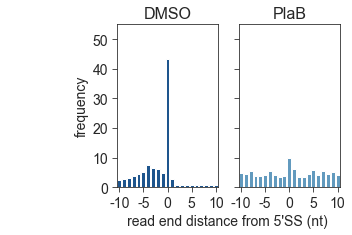

In [34]:
fig, ((ax1, ax2)) = plt.subplots(ncols=2, nrows=1, sharex=True, sharey=True, figsize=(4,3))

ax1 = sns.barplot(K562_DMSO_counts_df['index'],K562_DMSO_counts_df['freq'],color=sns.color_palette("Blues")[5], ax=ax1)
ax2 = sns.barplot(K562_PlaB_counts_df['index'],K562_PlaB_counts_df['freq'],color=sns.color_palette("Blues")[3], ax=ax2)

ax1.set_ylabel('frequency', fontsize=14)
ax2.set_ylabel('')

ax1.set_xlabel('                               read end distance from 5\'SS (nt)', fontsize=14)
ax2.set_xlabel('', fontsize=14)

plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)

x_labels=["-10","-5","0","5","10"]
plt.xticks([0,5,10,15,20], x_labels, fontsize=14)

plt.yticks([0,10,20,30,40,50], fontsize=14)

ax1.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)
ax2.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)

ax1.set_title("DMSO", fontsize=16)
ax2.set_title("PlaB", fontsize=16)

#plt.text(0,67,"Proportion of splicing intermediates (Human)",horizontalalignment='center', fontsize=16)

plt.ylim(0,55)

plt.savefig('/path/to/Figure_3F_Human_DMSO_vs_PlaB_splicing_intermediate_frequency_plot.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()


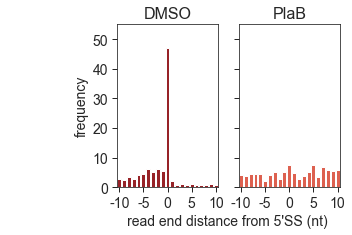

In [35]:
fig, ((ax1, ax2)) = plt.subplots(ncols=2, nrows=1, sharex=True, sharey=True, figsize=(4,3))

ax1 = sns.barplot(S2_DMSO_counts_df['index'],S2_DMSO_counts_df['freq'],color=sns.color_palette("Reds")[5], ax=ax1)
ax2 = sns.barplot(S2_PlaB_counts_df['index'],S2_PlaB_counts_df['freq'],color=sns.color_palette("Reds")[3], ax=ax2)

ax1.set_ylabel('frequency', fontsize=14)
ax2.set_ylabel('')

ax1.set_xlabel('                               read end distance from 5\'SS (nt)', fontsize=14)
ax2.set_xlabel('', fontsize=14)

plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)

x_labels=["-10","-5","0","5","10"]
plt.xticks([0,5,10,15,20], x_labels, fontsize=14)

plt.yticks([0,10,20,30,40,50], fontsize=14)

ax1.tick_params(direction='out', length=5, width=1)
ax2.tick_params(direction='out', length=5, width=1)

ax1.set_title("DMSO", fontsize=16)
ax2.set_title("PlaB", fontsize=16)

ax1.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)
ax2.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)

plt.ylim(0,55)

plt.savefig('/path/to/Figure_3F_Drosophila_DMSO_vs_PlaB_splicing_intermediate_frequency_plot.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()


In [2]:
# FIGURE 3G - nano-COP PlaB vs. DMSO terminal intron splicing plots

# These datasets were produced in the script nanoCOP_termination_df_datasets.ipynb


# upload files from directory

K562_DMSO_1_termination_df = pd.read_table("/path/to/K562_DMSO_1_hg38_termination_df.txt",header=0)
K562_DMSO_2_termination_df = pd.read_table("/path/to/K562_DMSO_2_hg38_termination_df.txt",header=0)
K562_PlaB_1_termination_df = pd.read_table("/path/to/K562_PlaB_1_hg38_termination_df.txt",header=0)
K562_PlaB_2_termination_df = pd.read_table("/path/to/K562_PlaB_2_hg38_termination_df.txt",header=0)


In [3]:
######### set variables for plot #########
polyA_min = -50
polyA_max = 50
post_min = 50      
post_max = 550     


######### get info for each K562 sample #########
plot_list = [] 

samples=['K562_DMSO_1','K562_DMSO_2'] 
species='Human'
treatment='DMSO'

for k in samples:
    name = '%s' % k # get name of sample
    df = eval('%s_termination_df' % k) # get termination file for this sample
    
    post_range = df[df['polyA_dist'].astype(int).between(post_min, post_max, inclusive=True)] 
    post_spliced = len(post_range[post_range['splice_status']=="YES"])
    post_unspliced = len(post_range[post_range['splice_status']=="NO"])

    if (post_spliced + post_unspliced) > 0: 
        post_percentSpliced = (float(post_spliced) / (float(post_spliced) + float(post_unspliced)))*100
        post_percentUnspliced = (float(post_unspliced) / (float(post_spliced) + float(post_unspliced)))*100
    elif (post_spliced + post_unspliced) == 0: 
        post_percentSpliced = 0.0
        post_percentUnspliced = 0.0
    
    post_percentSpliced = float("{0:.3f}".format(post_percentSpliced))
    post_percentUnspliced = float("{0:.3f}".format(post_percentUnspliced))

    plot_list.append([name, species, treatment, 'uncleaved', post_spliced, 'spliced', float(post_percentSpliced)])
    plot_list.append([name, species, treatment, 'uncleaved', post_unspliced, 'unspliced', float(post_percentUnspliced)])

    
    polyA_range = df[df['polyA_dist'].astype(int).between(polyA_min, polyA_max, inclusive=True)] 
    polyA_spliced = len(polyA_range[polyA_range['splice_status']=="YES"])
    polyA_unspliced = len(polyA_range[polyA_range['splice_status']=="NO"])
    
    if (polyA_spliced + polyA_unspliced) > 0: 
        polyA_percentSpliced = (float(polyA_spliced) / (float(polyA_spliced) + float(polyA_unspliced)))*100
        polyA_percentUnspliced = (float(polyA_unspliced) / (float(polyA_spliced) + float(polyA_unspliced)))*100
    elif (polyA_spliced + polyA_unspliced) == 0: 
        polyA_percentSpliced = 0.0
        polyA_percentUnspliced = 0.0
    
    polyA_percentSpliced = float("{0:.3f}".format(polyA_percentSpliced))
    polyA_percentUnspliced = float("{0:.3f}".format(polyA_percentUnspliced))
    
    plot_list.append([name, species, treatment, 'cleaved', polyA_spliced, 'spliced', float(polyA_percentSpliced)])
    plot_list.append([name, species, treatment, 'cleaved', polyA_unspliced, 'unspliced', float(polyA_percentUnspliced)])


samples=['K562_PlaB_1','K562_PlaB_2'] 
species='Human'
treatment='PlaB'

for k in samples:
    name = '%s' % k # get name of sample
    df = eval('%s_termination_df' % k) # get termination file for this sample
    
    post_range = df[df['polyA_dist'].astype(int).between(post_min, post_max, inclusive=True)] 
    post_spliced = len(post_range[post_range['splice_status']=="YES"])
    post_unspliced = len(post_range[post_range['splice_status']=="NO"])

    if (post_spliced + post_unspliced) > 0: 
        post_percentSpliced = (float(post_spliced) / (float(post_spliced) + float(post_unspliced)))*100
        post_percentUnspliced = (float(post_unspliced) / (float(post_spliced) + float(post_unspliced)))*100
    elif (post_spliced + post_unspliced) == 0: 
        post_percentSpliced = 0.0
        post_percentUnspliced = 0.0
    
    post_percentSpliced = float("{0:.3f}".format(post_percentSpliced))
    post_percentUnspliced = float("{0:.3f}".format(post_percentUnspliced))

    plot_list.append([name, species, treatment, 'uncleaved', post_spliced, 'spliced', float(post_percentSpliced)])
    plot_list.append([name, species, treatment, 'uncleaved', post_unspliced, 'unspliced', float(post_percentUnspliced)])

    
    polyA_range = df[df['polyA_dist'].astype(int).between(polyA_min, polyA_max, inclusive=True)] 
    polyA_spliced = len(polyA_range[polyA_range['splice_status']=="YES"])
    polyA_unspliced = len(polyA_range[polyA_range['splice_status']=="NO"])
    
    if (polyA_spliced + polyA_unspliced) > 0: 
        polyA_percentSpliced = (float(polyA_spliced) / (float(polyA_spliced) + float(polyA_unspliced)))*100
        polyA_percentUnspliced = (float(polyA_unspliced) / (float(polyA_spliced) + float(polyA_unspliced)))*100
    elif (polyA_spliced + polyA_unspliced) == 0: 
        polyA_percentSpliced = 0.0
        polyA_percentUnspliced = 0.0
    
    polyA_percentSpliced = float("{0:.3f}".format(polyA_percentSpliced))
    polyA_percentUnspliced = float("{0:.3f}".format(polyA_percentUnspliced))
    
    plot_list.append([name, species, treatment, 'cleaved', polyA_spliced, 'spliced', float(polyA_percentSpliced)])
    plot_list.append([name, species, treatment, 'cleaved', polyA_unspliced, 'unspliced', float(polyA_percentUnspliced)])

    
K562_plot_df = pd.DataFrame(plot_list)
K562_plot_df.columns = ['name','species', 'treatment', 'position','count','splice_status','percent']


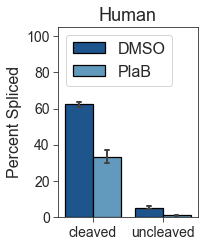

In [47]:

######### plot mean and standard deviation for all samples #########

spliced_plot_df = K562_plot_df[K562_plot_df['splice_status']=='spliced']

fig, ax = plt.subplots(figsize=(2.5,3.5))

fill_colors = [sns.color_palette("Blues")[5],sns.color_palette("Blues")[3]]
ax = sns.barplot(x='position', y='percent', hue='treatment', data=spliced_plot_df, palette=fill_colors, 
                 order = ['cleaved','uncleaved'], edgecolor = ['black','black'], linewidth=1.25, capsize=.05, errwidth=2, ci=100)

plt.ylabel("Percent Spliced", fontsize=16)
plt.xlabel("", fontsize=18, labelpad=10)
#plt.xlabel("Position of the read 3'end", fontsize=18, labelpad=10)
#plt.suptitle("Splicing status of terminal introns", fontsize=20)

plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)

plt.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)

plt.ylim(0,105)
plt.legend(loc=2, fontsize=16)
plt.title("Human", fontsize=18)

plt.savefig('/path/to/Figure_3G_Human_DMSO_vs_PlaB_terminal_intron_splicing_plot.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()


In [4]:
K562_plot_df.head()

,name,species,treatment,position,count,splice_status,percent
0,HL14,Human,DMSO,uncleaved,57,spliced,6.077
1,HL14,Human,DMSO,uncleaved,881,unspliced,93.923
2,HL14,Human,DMSO,cleaved,3678,spliced,63.666
3,HL14,Human,DMSO,cleaved,2099,unspliced,36.334
4,HL19,Human,DMSO,uncleaved,65,spliced,4.683


In [6]:
# Statistical test to show that the difference between cleaved and uncleaved is significant

# K562 cleaved
# get values for Fisher exact test and Chi squared test
DMSO_spliced = np.sum(K562_plot_df[(K562_plot_df['treatment']=='DMSO') & (K562_plot_df['splice_status']=='spliced') & (K562_plot_df['position']=='cleaved')]['count'])
DMSO_unspliced = np.sum(K562_plot_df[(K562_plot_df['treatment']=='DMSO') & (K562_plot_df['splice_status']=='unspliced') & (K562_plot_df['position']=='cleaved')]['count'])
PlaB_spliced = np.sum(K562_plot_df[(K562_plot_df['treatment']=='PlaB') & (K562_plot_df['splice_status']=='spliced') & (K562_plot_df['position']=='cleaved')]['count'])
PlaB_unspliced = np.sum(K562_plot_df[(K562_plot_df['treatment']=='PlaB') & (K562_plot_df['splice_status']=='unspliced') & (K562_plot_df['position']=='cleaved')]['count'])


oddsratio, pvalue = stats.fisher_exact([[DMSO_spliced, DMSO_unspliced], [PlaB_spliced, PlaB_unspliced]])
pvalue # the same equation in R shows that this is <2.2e-16

if (pvalue==0):
    print("Fisher exact p-value: <2.2e-16")

if (pvalue>0):
    print("Fisher exact p-value: "+str(pvalue))
      

g, pvalue, dof, expctd = chi2_contingency(np.array([[DMSO_spliced, DMSO_unspliced], [PlaB_spliced, PlaB_unspliced]]))
pvalue # the same equation in R shows that this is <2.2e-16

if (pvalue==0):
    print("chi-square p-value: <2.2e-16")

if (pvalue>0):
    print("chi-square p-value: "+str(pvalue))




Fisher exact p-value: <2.2e-16
chi-square p-value: <2.2e-16


In [7]:
# Statistical test to show that the difference between uncleaved and ununcleaved is significant

# K562 uncleaved
# get values for Fisher exact test and Chi squared test
DMSO_spliced = np.sum(K562_plot_df[(K562_plot_df['treatment']=='DMSO') & (K562_plot_df['splice_status']=='spliced') & (K562_plot_df['position']=='uncleaved')]['count'])
DMSO_unspliced = np.sum(K562_plot_df[(K562_plot_df['treatment']=='DMSO') & (K562_plot_df['splice_status']=='unspliced') & (K562_plot_df['position']=='uncleaved')]['count'])
PlaB_spliced = np.sum(K562_plot_df[(K562_plot_df['treatment']=='PlaB') & (K562_plot_df['splice_status']=='spliced') & (K562_plot_df['position']=='uncleaved')]['count'])
PlaB_unspliced = np.sum(K562_plot_df[(K562_plot_df['treatment']=='PlaB') & (K562_plot_df['splice_status']=='unspliced') & (K562_plot_df['position']=='uncleaved')]['count'])


oddsratio, pvalue = stats.fisher_exact([[DMSO_spliced, DMSO_unspliced], [PlaB_spliced, PlaB_unspliced]])
pvalue # the same equation in R shows that this is <2.2e-16

if (pvalue==0):
    print("Fisher exact p-value: <2.2e-16")

if (pvalue>0):
    print("Fisher exact p-value: "+str(pvalue))
      

g, pvalue, dof, expctd = chi2_contingency(np.array([[DMSO_spliced, DMSO_unspliced], [PlaB_spliced, PlaB_unspliced]]))
pvalue # the same equation in R shows that this is <2.2e-16

if (pvalue==0):
    print("chi-square p-value: <2.2e-16")

if (pvalue>0):
    print("chi-square p-value: "+str(pvalue))




Fisher exact p-value: 2.609654899594516e-16
chi-square p-value: 1.1494017459267929e-14


In [8]:
# FIGURE 3G - nano-COP PlaB vs. DMSO terminal intron splicing plots - Drosophila

# These datasets were produced in the script nanoCOP_termination_df_datasets.ipynb

# upload files from directory

S2_DMSO_1_termination_df = pd.read_table("/path/to/S2_DMSO_1_dm6_termination_df.txt",header=0)
S2_DMSO_2_termination_df = pd.read_table("/path/to/S2_DMSO_2_dm6_termination_df.txt",header=0)
S2_PlaB_1_termination_df = pd.read_table("/path/to/S2_PlaB_1_dm6_termination_df.txt",header=0)
S2_PlaB_2_termination_df = pd.read_table("/path/to/S2_PlaB_2_dm6_termination_df.txt",header=0)



In [9]:
######### set variables for plot #########
polyA_min = -50
polyA_max = 50
post_min = 50      
post_max = 550     


######### get info for each S2 sample #########
plot_list = [] 

samples=['S2_DMSO_1','S2_DMSO_2'] 
species='Drosophila'
treatment='DMSO'

for k in samples:
    name = '%s' % k # get name of sample
    df = eval('%s_termination_df' % k) # get termination file for this sample
    
    post_range = df[df['polyA_dist'].astype(int).between(post_min, post_max, inclusive=True)] 
    post_spliced = len(post_range[post_range['splice_status']=="YES"])
    post_unspliced = len(post_range[post_range['splice_status']=="NO"])

    if (post_spliced + post_unspliced) > 0: 
        post_percentSpliced = (float(post_spliced) / (float(post_spliced) + float(post_unspliced)))*100
        post_percentUnspliced = (float(post_unspliced) / (float(post_spliced) + float(post_unspliced)))*100
    elif (post_spliced + post_unspliced) == 0: 
        post_percentSpliced = 0.0
        post_percentUnspliced = 0.0
    
    post_percentSpliced = float("{0:.3f}".format(post_percentSpliced))
    post_percentUnspliced = float("{0:.3f}".format(post_percentUnspliced))

    plot_list.append([name, species, treatment, 'uncleaved', post_spliced, 'spliced', float(post_percentSpliced)])
    plot_list.append([name, species, treatment, 'uncleaved', post_unspliced, 'unspliced', float(post_percentUnspliced)])

    
    polyA_range = df[df['polyA_dist'].astype(int).between(polyA_min, polyA_max, inclusive=True)] 
    polyA_spliced = len(polyA_range[polyA_range['splice_status']=="YES"])
    polyA_unspliced = len(polyA_range[polyA_range['splice_status']=="NO"])
    
    if (polyA_spliced + polyA_unspliced) > 0: 
        polyA_percentSpliced = (float(polyA_spliced) / (float(polyA_spliced) + float(polyA_unspliced)))*100
        polyA_percentUnspliced = (float(polyA_unspliced) / (float(polyA_spliced) + float(polyA_unspliced)))*100
    elif (polyA_spliced + polyA_unspliced) == 0: 
        polyA_percentSpliced = 0.0
        polyA_percentUnspliced = 0.0
    
    polyA_percentSpliced = float("{0:.3f}".format(polyA_percentSpliced))
    polyA_percentUnspliced = float("{0:.3f}".format(polyA_percentUnspliced))
    
    plot_list.append([name, species, treatment, 'cleaved', polyA_spliced, 'spliced', float(polyA_percentSpliced)])
    plot_list.append([name, species, treatment, 'cleaved', polyA_unspliced, 'unspliced', float(polyA_percentUnspliced)])


samples=['S2_PlaB_1','S2_PlaB_2'] 
species='Drosophila'
treatment='PlaB'

for k in samples:
    name = '%s' % k # get name of sample
    df = eval('%s_termination_df' % k) # get termination file for this sample
    
    post_range = df[df['polyA_dist'].astype(int).between(post_min, post_max, inclusive=True)] 
    post_spliced = len(post_range[post_range['splice_status']=="YES"])
    post_unspliced = len(post_range[post_range['splice_status']=="NO"])

    if (post_spliced + post_unspliced) > 0: 
        post_percentSpliced = (float(post_spliced) / (float(post_spliced) + float(post_unspliced)))*100
        post_percentUnspliced = (float(post_unspliced) / (float(post_spliced) + float(post_unspliced)))*100
    elif (post_spliced + post_unspliced) == 0: 
        post_percentSpliced = 0.0
        post_percentUnspliced = 0.0
    
    post_percentSpliced = float("{0:.3f}".format(post_percentSpliced))
    post_percentUnspliced = float("{0:.3f}".format(post_percentUnspliced))

    plot_list.append([name, species, treatment, 'uncleaved', post_spliced, 'spliced', float(post_percentSpliced)])
    plot_list.append([name, species, treatment, 'uncleaved', post_unspliced, 'unspliced', float(post_percentUnspliced)])

    
    polyA_range = df[df['polyA_dist'].astype(int).between(polyA_min, polyA_max, inclusive=True)] 
    polyA_spliced = len(polyA_range[polyA_range['splice_status']=="YES"])
    polyA_unspliced = len(polyA_range[polyA_range['splice_status']=="NO"])
    
    if (polyA_spliced + polyA_unspliced) > 0: 
        polyA_percentSpliced = (float(polyA_spliced) / (float(polyA_spliced) + float(polyA_unspliced)))*100
        polyA_percentUnspliced = (float(polyA_unspliced) / (float(polyA_spliced) + float(polyA_unspliced)))*100
    elif (polyA_spliced + polyA_unspliced) == 0: 
        polyA_percentSpliced = 0.0
        polyA_percentUnspliced = 0.0
    
    polyA_percentSpliced = float("{0:.3f}".format(polyA_percentSpliced))
    polyA_percentUnspliced = float("{0:.3f}".format(polyA_percentUnspliced))
    
    plot_list.append([name, species, treatment, 'cleaved', polyA_spliced, 'spliced', float(polyA_percentSpliced)])
    plot_list.append([name, species, treatment, 'cleaved', polyA_unspliced, 'unspliced', float(polyA_percentUnspliced)])

    
S2_plot_df = pd.DataFrame(plot_list)
S2_plot_df.columns = ['name','species', 'treatment', 'position','count','splice_status','percent']


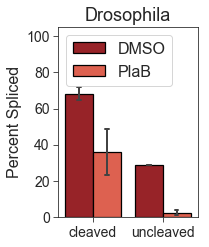

In [46]:

######### plot mean and standard deviation for all samples #########

spliced_plot_df = S2_plot_df[S2_plot_df['splice_status']=='spliced']

fig, ax = plt.subplots(figsize=(2.5,3.5))

fill_colors = [sns.color_palette("Reds")[5],sns.color_palette("Reds")[3]]
ax = sns.barplot(x='position', y='percent', hue='treatment', data=spliced_plot_df, palette=fill_colors, 
                 order = ['cleaved','uncleaved'], edgecolor = ['black','black'], linewidth=1.25, capsize=.05, errwidth=2, ci=100)

plt.ylabel("Percent Spliced", fontsize=16)
plt.xlabel("", fontsize=18, labelpad=10)
#plt.xlabel("Position of the read 3'end", fontsize=18, labelpad=10)
#plt.suptitle("Splicing status of terminal introns", fontsize=20)

plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)

plt.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)

plt.ylim(0,105)
plt.legend(loc=2, fontsize=16)
plt.title("Drosophila", fontsize=18)

plt.savefig('/path/to/Figure_3G_Drosophila_DMSO_vs_PlaB_terminal_intron_splicing_plot.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()


In [32]:
# Statistical test to show that the difference between cleaved and uncleaved is significant

# S2 cleaved
# get values for Fisher exact test and Chi squared test
DMSO_spliced = np.sum(S2_plot_df[(S2_plot_df['treatment']=='DMSO') & (S2_plot_df['splice_status']=='spliced') & (S2_plot_df['position']=='cleaved')]['count'])
DMSO_unspliced = np.sum(S2_plot_df[(S2_plot_df['treatment']=='DMSO') & (S2_plot_df['splice_status']=='unspliced') & (S2_plot_df['position']=='cleaved')]['count'])
PlaB_spliced = np.sum(S2_plot_df[(S2_plot_df['treatment']=='PlaB') & (S2_plot_df['splice_status']=='spliced') & (S2_plot_df['position']=='cleaved')]['count'])
PlaB_unspliced = np.sum(S2_plot_df[(S2_plot_df['treatment']=='PlaB') & (S2_plot_df['splice_status']=='unspliced') & (S2_plot_df['position']=='cleaved')]['count'])


oddsratio, pvalue = stats.fisher_exact([[DMSO_spliced, DMSO_unspliced], [PlaB_spliced, PlaB_unspliced]])
pvalue # the same equation in R shows that this is <2.2e-16

if (pvalue==0):
    print("Fisher exact p-value: <2.2e-16")

if (pvalue>0):
    print("Fisher exact p-value: "+str(pvalue))
      

g, pvalue, dof, expctd = chi2_contingency(np.array([[DMSO_spliced, DMSO_unspliced], [PlaB_spliced, PlaB_unspliced]]))
pvalue # the same equation in R shows that this is <2.2e-16

if (pvalue==0):
    print("chi-square p-value: <2.2e-16")

if (pvalue>0):
    print("chi-square p-value: "+str(pvalue))



Fisher exact p-value: 3.001307272503859e-105
chi-square p-value: 3.0804450287553447e-106


In [33]:
# Statistical test to show that the difference between uncleaved and ununcleaved is significant

# S2 uncleaved
# get values for Fisher exact test and Chi squared test
DMSO_spliced = np.sum(S2_plot_df[(S2_plot_df['treatment']=='DMSO') & (S2_plot_df['splice_status']=='spliced') & (S2_plot_df['position']=='uncleaved')]['count'])
DMSO_unspliced = np.sum(S2_plot_df[(S2_plot_df['treatment']=='DMSO') & (S2_plot_df['splice_status']=='unspliced') & (S2_plot_df['position']=='uncleaved')]['count'])
PlaB_spliced = np.sum(S2_plot_df[(S2_plot_df['treatment']=='PlaB') & (S2_plot_df['splice_status']=='spliced') & (S2_plot_df['position']=='uncleaved')]['count'])
PlaB_unspliced = np.sum(S2_plot_df[(S2_plot_df['treatment']=='PlaB') & (S2_plot_df['splice_status']=='unspliced') & (S2_plot_df['position']=='uncleaved')]['count'])


oddsratio, pvalue = stats.fisher_exact([[DMSO_spliced, DMSO_unspliced], [PlaB_spliced, PlaB_unspliced]])
pvalue # the same equation in R shows that this is <2.2e-16

if (pvalue==0):
    print("Fisher exact p-value: <2.2e-16")

if (pvalue>0):
    print("Fisher exact p-value: "+str(pvalue))
      

g, pvalue, dof, expctd = chi2_contingency(np.array([[DMSO_spliced, DMSO_unspliced], [PlaB_spliced, PlaB_unspliced]]))
pvalue # the same equation in R shows that this is <2.2e-16

if (pvalue==0):
    print("chi-square p-value: <2.2e-16")

if (pvalue>0):
    print("chi-square p-value: "+str(pvalue))



Fisher exact p-value: 3.662663371707152e-82
chi-square p-value: 1.6034692385263762e-62
